###  MicroGrad demo

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [12]:
np.random.seed(1337)
random.seed(1337)

In [13]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [14]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

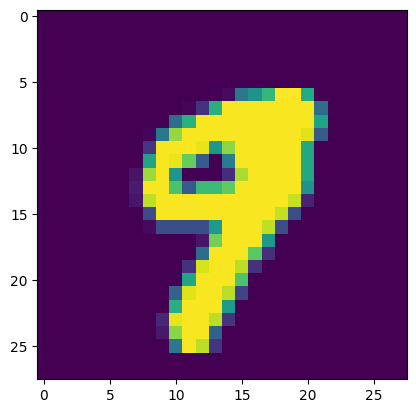

In [15]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [16]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(y, classes):
    noise = np.array([0.0] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([-1.0] * len(classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decode(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    return oh_decode, np.array([oh_enc[cls] for cls in y])

OH_DECODER, Y_oh = oh_encode(Y_train, POSITIVE_CLASSES)
Y_oh.shape

(60000, 10)

In [21]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(
    784,
    [
        (10, 'tanh')
    ]
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784), tanh-Neuron(784)]]
number of parameters 7850


In [18]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [19]:
# loss function
def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return loss(scores, expected), accuracy(scores, expected)

In [22]:
BATCH_SIZE = 16
X_b, Y_b = get_batch(X_train, Y_oh, BATCH_SIZE)

# optimization
for k in range(10):
    total_loss, acc = evaluate(model, X_b, Y_b)
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    model.learn_from(total_loss, 1)

total_loss, acc = evaluate(model, X_b, Y_b)
print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 496.5158644016144, accuracy 0.0%
step 1 loss 387.43508060538835, accuracy 0.0%
step 2 loss 331.9993680428693, accuracy 0.0%
step 3 loss 331.9967025563721, accuracy 0.0%
step 4 loss 328.11280674033515, accuracy 0.0%
step 5 loss 268.0000040700552, accuracy 0.0%
step 6 loss 268.0000036599159, accuracy 0.0%
step 7 loss 268.0000032996887, accuracy 0.0%
step 8 loss 268.00000298045086, accuracy 0.0%
step 9 loss 268.0000026952976, accuracy 0.0%
step 9 loss 268.00000243879987, accuracy 0.0%
final loss 268.00000243879987, accuracy 0.0%
